https://github.com/tintn/vision-transformer-from-scratch

## ViT Implementation

In [ ]:
import torch
from torch import nn

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    """
    Multi-head attention module.
    This module is used in the TransformerEncoder module.
    """

    def __init__(self, config):
        super().__init__()
        self.layer = nn.MultiheadAttention(
            embed_dim=config["hidden_size"],
            num_heads=config["num_attention_heads"],
            bias=config["bias"],
            batch_first=True,
            dropout=config["attention_probs_dropout_prob"]
        )

    def forward(self, x, output_attentions=False):
        attention_output, attention_probs = self.layer(x, x, x, average_attn_weights=False)

        # Return the attention output and the attention probabilities (optional)
        if not output_attentions:
            return (attention_output, None)
        else:
            return (attention_output, attention_probs)

In [ ]:
x = torch.randn(1, 99, 48) # (batch_size, seq_len, hidden_size)
config = {
    "hidden_size": 48,
    "num_attention_heads": 4,
    "bias": True,
    "attention_probs_dropout_prob": 0.1
}
layer = MultiHeadSelfAttention(config)
output, probs = layer(x, output_attentions=True)
print(output.shape)
print(probs.shape)

torch.Size([1, 99, 48])
torch.Size([1, 4, 99, 99])


In [ ]:
class MLP(nn.Module):
    """
    A multi-layer perceptron module.
    """

    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.activation = nn.GELU()
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x

In [ ]:
class Block(nn.Module):
    """
    A single transformer block.
    """

    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadSelfAttention(config)
        self.layernorm_1 = nn.LayerNorm(config["hidden_size"])
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["hidden_size"])

    def forward(self, x, output_attentions=False):
        # Norm + Self-attention
        attention_output, attention_probs = \
            self.attention(self.layernorm_1(x), output_attentions=output_attentions)
        # Skip connection
        x = x + attention_output
        # Norm + Feed-forward network
        mlp_output = self.mlp(self.layernorm_2(x))
        # Skip connection
        x = x + mlp_output
        # Return the transformer block's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)

In [ ]:
class Encoder(nn.Module):
    """
    The transformer encoder module.
    """

    def __init__(self, config):
        super().__init__()
        # Create a list of transformer blocks
        self.blocks = nn.ModuleList([])
        for _ in range(config["num_hidden_layers"]):
            block = Block(config)
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):
        # Calculate the transformer block's output for each block
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        # Return the encoder's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)

In [ ]:
class PatchEmbeddings(nn.Module):
    """
    Convert the image into patches and then project them into a vector space.
    """

    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]
        # Calculate the number of patches from the image size and patch size
        self.num_patches = (self.image_size // self.patch_size) ** 2
        # Create a projection layer to convert the image into patches
        # The layer projects each patch into a vector of size hidden_size
        self.projection = nn.Conv2d(self.num_channels, self.hidden_size, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x


class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)
        # Create a learnable [CLS] token
        # Similar to BERT, the [CLS] token is added to the beginning of the input sequence
        # and is used to classify the entire sequence
        self.cls_token = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))
        # Create position embeddings for the [CLS] token and the patch embeddings
        # Add 1 to the sequence length for the [CLS] token
        self.position_embeddings = \
            nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, config["hidden_size"]))
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        # Expand the [CLS] token to the batch size
        # (1, 1, hidden_size) -> (batch_size, 1, hidden_size)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        # Concatenate the [CLS] token to the beginning of the input sequence
        # This results in a sequence length of (num_patches + 1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x

In [ ]:
class ViTForClassfication(nn.Module):
    """
    The ViT model for classification.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        self.num_classes = config["num_classes"]
        # Create the embedding module
        self.embedding = Embeddings(config)
        # Create the transformer encoder module
        self.encoder = Encoder(config)
        # Create a linear layer to project the encoder's output to the number of classes
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)
        # Initialize the weights
        self.apply(self._init_weights)

    def forward(self, x, output_attentions=False):
        # Calculate the embedding output
        embedding_output = self.embedding(x)
        # Calculate the encoder's output
        encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)
        # Calculate the logits, take the [CLS] token's output as features for classification
        logits = self.classifier(encoder_output[:, 0, :])
        # Return the logits and the attention probabilities (optional)
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.cls_token.dtype)

In [ ]:
x = torch.randn(1, 3, 32, 32) # (batch_size, num_channels, image_size, image_size)
config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 = 64 patches
    "hidden_size": 48,
    "num_hidden_layers": 6,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10, # num_classes of CIFAR10
    "num_channels": 3,
    "bias": True,
    "use_faster_attention": True,
}
layer = ViTForClassfication(config)
embedding_output = layer.embedding(x)
print(embedding_output.shape) # (batch_size, num_patches + 1, hidden_size)
encoder_output, all_attentions = layer.encoder(embedding_output, output_attentions=True)
print(encoder_output.shape) # (batch_size, num_patches + 1, hidden_size)
print(all_attentions[0].shape) # (batch_size, num_attention_heads, num_patches + 1, num_patches + 1)
print(len(all_attentions)) # num_hidden_layers
logits = layer.classifier(encoder_output[:, 0, :])
print(logits.shape) # (batch_size, num_classes)

torch.Size([1, 65, 48])
torch.Size([1, 65, 48])
torch.Size([1, 4, 65, 65])
6
torch.Size([1, 10])


## Prepare Data

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
def prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):
    train_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=train_transform)
    if train_sample_size is not None:
        # Randomly sample a subset of the training set
        indices = torch.randperm(len(trainset))[:train_sample_size]
        trainset = torch.utils.data.Subset(trainset, indices)



    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)

    test_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=test_transform)
    if test_sample_size is not None:
        # Randomly sample a subset of the test set
        indices = torch.randperm(len(testset))[:test_sample_size]
        testset = torch.utils.data.Subset(testset, indices)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)

    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    return trainloader, testloader, classes

## Utils

In [ ]:
import json, os, math
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms


def save_experiment(experiment_name, config, model, train_losses, test_losses, accuracies, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)

    # Save the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'w') as f:
        json.dump(config, f, sort_keys=True, indent=4)

    # Save the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'w') as f:
        data = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'accuracies': accuracies,
        }
        json.dump(data, f, sort_keys=True, indent=4)

    # Save the model
    save_checkpoint(experiment_name, model, "final", base_dir=base_dir)


def save_checkpoint(experiment_name, model, epoch, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)
    cpfile = os.path.join(outdir, f'model_{epoch}.pt')
    torch.save(model.state_dict(), cpfile)


def load_experiment(experiment_name, checkpoint_name="model_final.pt", base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    # Load the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'r') as f:
        config = json.load(f)
    # Load the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'r') as f:
        data = json.load(f)
    train_losses = data['train_losses']
    test_losses = data['test_losses']
    accuracies = data['accuracies']
    # Load the model
    model = ViTForClassfication(config)
    cpfile = os.path.join(outdir, checkpoint_name)
    model.load_state_dict(torch.load(cpfile))
    return config, model, train_losses, test_losses, accuracies


def visualize_images():
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True)
    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    # Pick 30 samples randomly
    indices = torch.randperm(len(trainset))[:30]
    images = [np.asarray(trainset[i][0]) for i in indices]
    labels = [trainset[i][1] for i in indices]
    # Visualize the images using matplotlib
    fig = plt.figure(figsize=(10, 10))
    for i in range(30):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        ax.imshow(images[i])
        ax.set_title(classes[labels[i]])


@torch.no_grad()
def visualize_attention(model, output=None, device="cuda"):
    """
    Visualize the attention maps.
    """
    model.eval()
    # Load random images
    num_images = 30
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    # Pick 30 samples randomly
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices]
    labels = [testset[i][1] for i in indices]
    # Convert the images to tensors
    test_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    images = torch.stack([test_transform(image) for image in raw_images])
    # Move the images to the device
    images = images.to(device)
    model = model.to(device)
    # Get the attention maps from the last block
    logits, attention_maps = model(images, output_attentions=True)
    # Get the predictions
    predictions = torch.argmax(logits, dim=1)
    # Concatenate the attention maps from all blocks
    attention_maps = torch.cat(attention_maps, dim=1)
    # select only the attention maps of the CLS token
    attention_maps = attention_maps[:, :, 0, 1:]         # select CLS token row of attention matrix (attention weights of CLS token to all patches)
    # Then average the attention maps of the CLS token over all the heads
    attention_maps = attention_maps.mean(dim=1)          # (batch_size, 8x8)
    # Reshape the attention maps to a square   
    num_patches = attention_maps.size(-1)  
    size = int(math.sqrt(num_patches)) 
    attention_maps = attention_maps.view(-1, size, size) # (batch_size, 8, 8)
    # Resize the map to the size of the image
    attention_maps = attention_maps.unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(32, 32), mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)
    # Plot the images and the attention maps
    fig = plt.figure(figsize=(20, 10))
    mask = np.concatenate([np.ones((32, 32)), np.zeros((32, 32))], axis=1)
    for i in range(num_images):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        img = np.concatenate((raw_images[i], raw_images[i]), axis=1)
        ax.imshow(img)
        # Mask out the attention map of the left image
        extended_attention_map = np.concatenate((np.zeros((32, 32)), attention_maps[i].cpu()), axis=1)
        extended_attention_map = np.ma.masked_where(mask==1, extended_attention_map)
        ax.imshow(extended_attention_map, alpha=0.5, cmap='jet')
        # Show the ground truth and the prediction
        gt = classes[labels[i]]
        pred = classes[predictions[i]]
        ax.set_title(f"gt: {gt} / pred: {pred}", color=("green" if gt==pred else "red"))
    if output is not None:
        plt.savefig(output)
    plt.show()

## Visualize Dataset

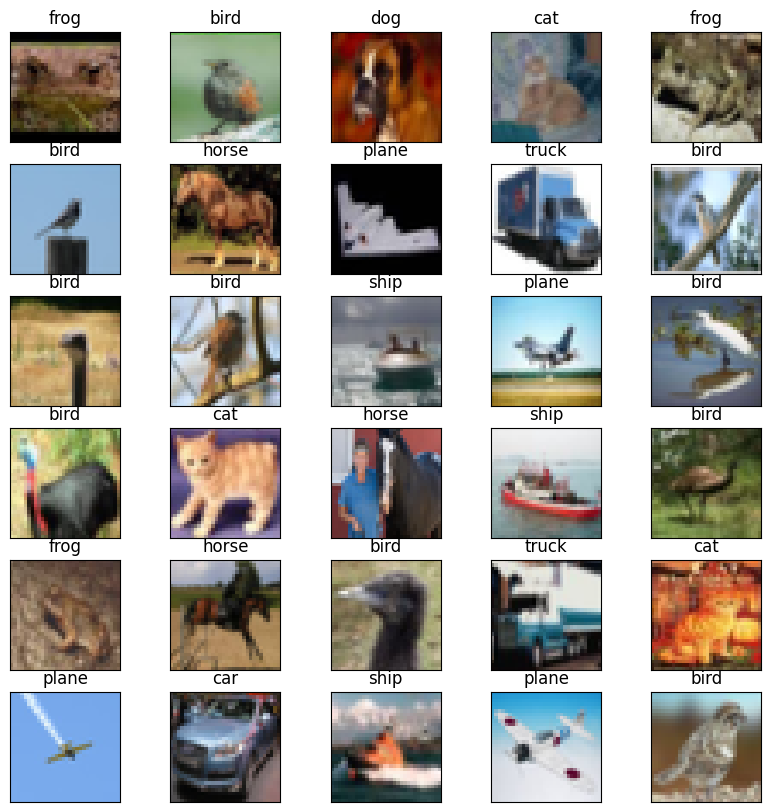

In [ ]:
visualize_images()

## Patch

In [ ]:
trainloader, _, _ = prepare_data(batch_size=1)

In [ ]:
sample = next(iter(trainloader))
len(sample)

2

In [ ]:
sample[0].shape, sample[1]

(torch.Size([1, 3, 32, 32]), tensor([3]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7915441..0.926057].


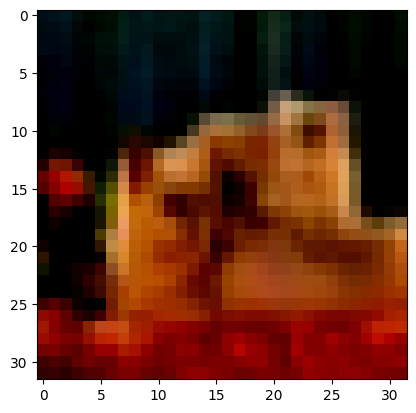

In [ ]:
plt.imshow(sample[0][0].permute(1,2,0).numpy());

In [ ]:
layer = nn.Conv2d(3, 5, kernel_size=16, stride=16)
output = layer(sample[0])
output.shape

torch.Size([1, 5, 2, 2])

In [ ]:
layer.weight.shape, layer.bias.shape

(torch.Size([5, 3, 16, 16]), torch.Size([5]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.58259803..0.8585249].


torch.Size([1, 3, 16, 16])


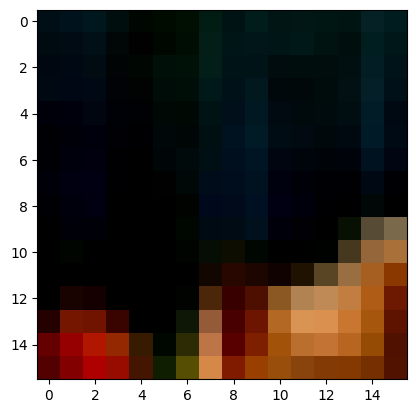

In [ ]:
patch = sample[0][:, :, :16, :16]
print(patch.shape)
plt.imshow(patch[0].permute(1,2,0).numpy());

In [ ]:
# convolution
(layer.weight[0] * patch).sum() + layer.bias[0]

tensor(0.0100, grad_fn=<AddBackward0>)

In [ ]:
# this output value is obtained by the convolution with the patch -> embedded patch!
output[0, 0, 0, 0]

tensor(0.0100, grad_fn=<SelectBackward0>)

## Train ViT

In [ ]:
exp_name = 'vit-with-10-epochs'
batch_size = 32
epochs = 10
lr = 1e-2 
save_model_every = 5

import torch
from torch import nn, optim
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "hidden_size": 48,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10, # num_classes of CIFAR10
    "num_channels": 3,
    "bias": True,
    "use_faster_attention": True,
}
# These are not hard constraints, but are used to prevent misconfigurations
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0


class Trainer:
    """
    The simple trainer.
    """

    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        """
        Train the model for the specified number of epochs.
        """
        # Keep track of the losses and accuracies
        train_losses, test_losses, accuracies = [], [], []
        # Train the model
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.exp_name, self.model, i+1)
        # Save the experiment
        save_experiment(self.exp_name, config, self.model, train_losses, test_losses, accuracies)

    def train_epoch(self, trainloader):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss = 0
        for batch in tqdm(trainloader):
            # Move the batch to the device
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            # Zero the gradients
            self.optimizer.zero_grad()
            # Calculate the loss
            loss = self.loss_fn(self.model(images)[0], labels)
            # Backpropagate the loss
            loss.backward()
            # Update the model's parameters
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in testloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get predictions
                logits, _ = self.model(images)

                # Calculate the loss
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss


def main():
    # Training parameters
    save_model_every_n_epochs = save_model_every
    # Load the CIFAR10 dataset
    trainloader, testloader, _ = prepare_data(batch_size=batch_size)
    # Create the model, optimizer, loss function and trainer
    model = ViTForClassfication(config)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
    trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every_n_epochs)


if __name__ == '__main__':
    main()

100%|█████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:15<00:00, 102.76it/s]


Epoch: 1, Train loss: 1.8175, Test loss: 1.6624, Accuracy: 0.4064


100%|█████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:15<00:00, 100.60it/s]


Epoch: 2, Train loss: 1.5332, Test loss: 1.4411, Accuracy: 0.4606


100%|█████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:15<00:00, 101.76it/s]


Epoch: 3, Train loss: 1.4378, Test loss: 1.4095, Accuracy: 0.5021


100%|█████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:15<00:00, 102.40it/s]


Epoch: 4, Train loss: 1.3829, Test loss: 1.3771, Accuracy: 0.4871


100%|█████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:15<00:00, 102.63it/s]


Epoch: 5, Train loss: 1.3440, Test loss: 1.2984, Accuracy: 0.5282
	Save checkpoint at epoch 5


100%|█████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:15<00:00, 102.13it/s]


Epoch: 6, Train loss: 1.3134, Test loss: 1.2688, Accuracy: 0.5462


100%|█████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:15<00:00, 101.36it/s]


Epoch: 7, Train loss: 1.2922, Test loss: 1.2345, Accuracy: 0.5489


100%|█████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:15<00:00, 102.54it/s]


Epoch: 8, Train loss: 1.2719, Test loss: 1.2916, Accuracy: 0.5406


100%|█████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:15<00:00, 100.57it/s]


Epoch: 9, Train loss: 1.2677, Test loss: 1.2532, Accuracy: 0.5481


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:15<00:00, 99.24it/s]


Epoch: 10, Train loss: 1.2546, Test loss: 1.2341, Accuracy: 0.5568


## Plot training results

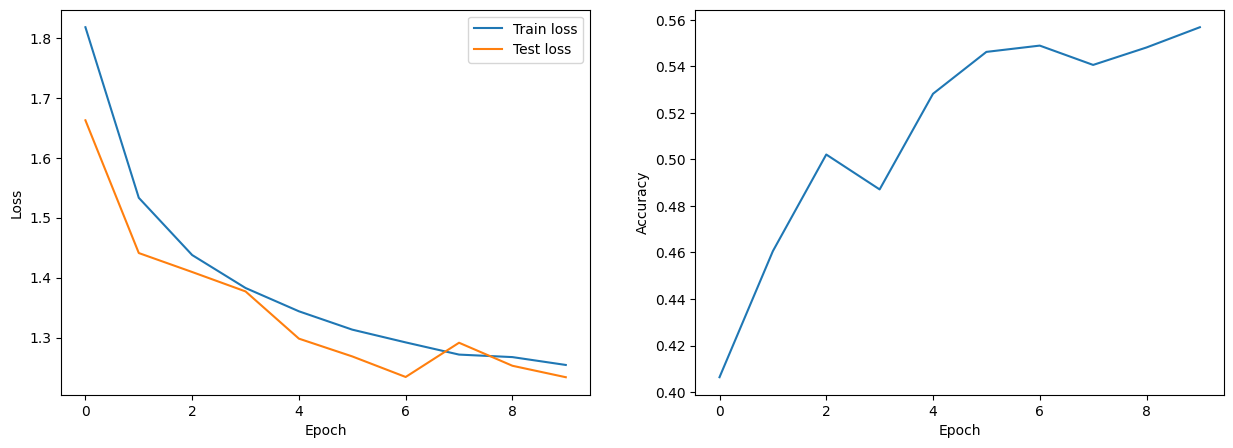

In [ ]:
config, model, train_losses, test_losses, accuracies = load_experiment(exp_name)

import matplotlib.pyplot as plt
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("metrics.png")
plt.show()

## Visualize Attention Maps

D:\win-ws\DL-KHU\.venv\lib\site-packages\torchvision\transforms\functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


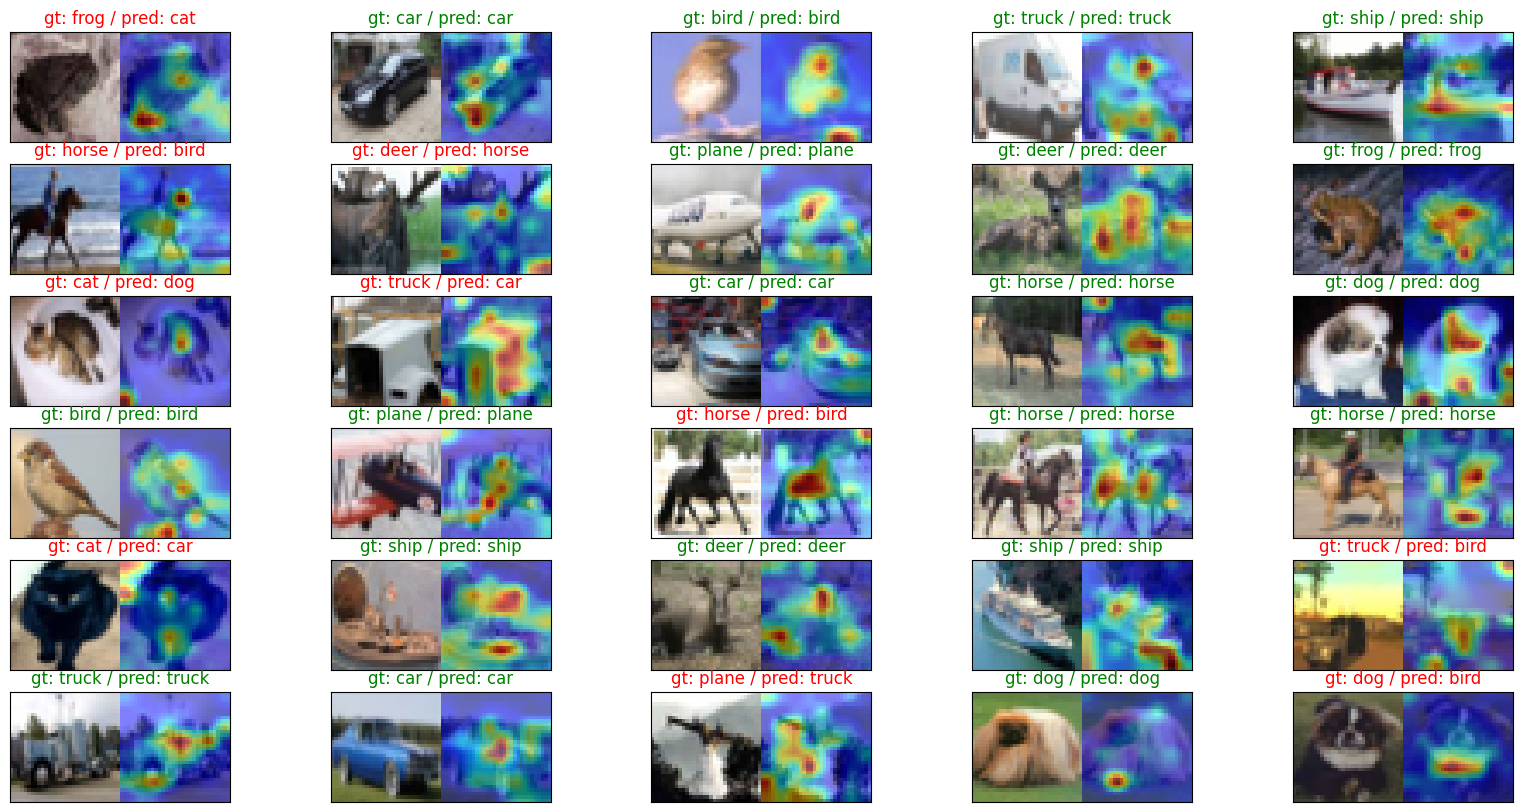

In [ ]:
visualize_attention(model, "attention.png")